In [3]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
#from sklearn.calibration import CalibratedClassifierCV
path = r'C:\Users\user\Documents\GitHub\Notebooks-on-ml\TITANIC\Data\train.csv'
df = pd.read_csv(path)

train_df_raw, val_df_raw = train_test_split(df, test_size=0.2, random_state=42)

def get_safe_survival_mapping(train_fs, test_fs):
    train_fs = train_fs.copy()
    test_fs = test_fs.copy()

    for df in [train_fs, test_fs]:
        df['Surname'] = df['Name'].apply(lambda x: x.split(',')[0])
        df['Is_Adult_Male'] = df['Name'].str.contains(r'Mr\.').astype(int)

    train_fs['Family_Survival'] = 0.5
    test_fs['Family_Survival'] = 0.5

    for _, group in train_fs.groupby(['Surname', 'Fare']):
        if len(group) > 1:
            for ind, row in group.iterrows():
                others = group.drop(ind)
                if others['Survived'].max() == 1.0:
                    train_fs.loc[ind, 'Family_Survival'] = 1
                elif others['Survived'].max() == 0.0:
                    train_fs.loc[ind, 'Family_Survival'] = 0

    for _, group in train_fs.groupby('Ticket'):
        if len(group) > 1:
            for ind, row in group.iterrows():
                if train_fs.loc[ind, 'Family_Survival'] == 0.5:
                    others = group.drop(ind)
                    if others['Survived'].max() == 1.0:
                        train_fs.loc[ind, 'Family_Survival'] = 1
                    elif others['Survived'].max() == 0.0:
                        train_fs.loc[ind, 'Family_Survival'] = 0

    for ind, row in test_fs.iterrows():
        if row['Is_Adult_Male'] == 1:
            test_fs.loc[ind, 'Family_Survival'] = 0
            continue

        fam_in_train = train_fs[(train_fs['Surname'] == row['Surname']) & (train_fs['Fare'] == row['Fare'])]
        ticket_in_train = train_fs[train_fs['Ticket'] == row['Ticket']]
        combined = pd.concat([fam_in_train, ticket_in_train])

        if len(combined) > 0:
            if combined['Survived'].max() == 1.0:
                test_fs.loc[ind, 'Family_Survival'] = 1
            elif combined['Survived'].max() == 0.0:
                test_fs.loc[ind, 'Family_Survival'] = 0

    full_mapping = pd.concat([train_fs[['PassengerId', 'Family_Survival']],
                                    test_fs[['PassengerId', 'Family_Survival']]])
    return full_mapping

train_stats = train_df_raw.copy()
train_stats['Deck'] = train_stats['Cabin'].str[0].fillna('M')
stats_lookup = train_stats.groupby(['Pclass', 'Deck'])['Survived'].mean().reset_index()
stats_lookup.columns = ['Pclass', 'Deck', 'Group_Survival_Rate']

def prepare_data(df_input, survival_mapping, train_stats=None):
    df = df_input.copy()

    df['Is_Adult_Male'] = df['Name'].str.contains(r'Mr\.').astype(int)
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(float)
    df['IsMother'] = ((df['Sex'] == 1) & (df['Parch'] > 0) & (df['Age'] > 18)).astype(float)
    df['IsChild'] = (df['Age'] < 14).astype(float)
    df['IsFather'] = ((df['Is_Adult_Male'] == 1) & (df['Parch'] > 0)).astype(float)

    median_fare = df.groupby('Pclass')['Fare'].median()[3]
    df['Fare'] = df['Fare'].fillna(median_fare)
    df['Ticket_Group_Size'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Fare_Individual'] = df['Fare'] / df['FamilySize'].fillna(df['Fare'])
    df['Fare_Individual_Log'] = df['Fare_Individual'].apply(lambda x: np.log1p(x) if x > 0 else 0).fillna(np.log1p(df['Fare']))
    df['Fare_Log'] = df['Fare'].apply(lambda x: np.log1p(x) if x > 0 else 0).fillna(df['Fare'])
    
    df['Has_Cabin'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
    df['Deck'] = df['Cabin'].str[0].fillna('M')
    deck_mapping = {'B': 0.74, 'D': 0.75, 'E': 0.75, 'C': 0.59, 'F': 0.61, 'Rare': 0.45, 'M': 0.23}
    df['Deck_Score'] = df['Deck'].map(deck_mapping).fillna(0.23)
    
    if train_stats is not None:
        df = df.merge(train_stats, on=['Pclass', 'Deck'], how='left')
        pclass_fill = {1: 0.63, 2: 0.47, 3: 0.24} 
        df['Group_Survival_Rate'] = df['Group_Survival_Rate'].fillna(df['Pclass'].map(pclass_fill))

    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
    title_mapping = {
        'Rev': 'Service', 'Dr': 'Service',
        'Jonkheer': 'Noble', 'Don': 'Noble', 'Sir': 'Noble', 'Lady': 'Noble', 'Countess': 'Noble', 'Dona': 'Noble',
        'Capt': 'Officer', 'Col': 'Officer', 'Major': 'Officer',
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'
    }
    df['Title'] = df['Title'].replace(title_mapping)
    df['Title'] = df['Title'].replace(['Noble', 'Officer', 'Service'], 'Elite&Other')

    df['Age'] = df.groupby(['Pclass', 'Sex', 'Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    df = df.merge(survival_mapping, on='PassengerId', how='left')
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch', 'Is_Adult_Male']
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    df = pd.get_dummies(df)
    return df.astype(float)

fs_map = get_safe_survival_mapping(train_df_raw, val_df_raw)

X_train = prepare_data(train_df_raw, fs_map, train_stats=stats_lookup).drop(columns=['Survived'])
y_train = train_df_raw['Survived']

X_val = prepare_data(val_df_raw, fs_map, train_stats=stats_lookup).drop(columns=['Survived'])
y_val = val_df_raw['Survived']

X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

def objective(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.02, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.1, 2.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }
    
    #w1 = trial.suggest_float('weight_rf', 0.5, 1.0)
    #w2 = trial.suggest_float('weight_xgb', 0.1, 0.5)
    
    rf_model = RandomForestClassifier(
    n_estimators=500, max_depth=5, min_samples_split=17, 
    min_samples_leaf=16, max_features='sqrt', criterion='entropy', random_state=42
    )

    xgb_model = XGBClassifier(**xgb_params)

    ensemble = StackingClassifier(
        estimators=[('rf', rf_model), ('xgb', xgb_model)],
        final_estimator=LogisticRegression(),
        cv=5,
        n_jobs=-1
    )

    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv = cross_val_score(ensemble, X_train, y_train, cv=skf, n_jobs=-1)

    return cv.mean() - cv.std()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params.copy()
#w_rf = best_params.pop('weight_rf')
#w_xgb = best_params.pop('weight_xgb')
best_xgb = XGBClassifier(**study.best_params, random_state=42)
best_rf = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_split=17,  min_samples_leaf=16, max_features='sqrt', criterion='entropy', random_state=42)

calibrated_xgb = CalibratedClassifierCV(best_xgb, method='sigmoid', cv=5)
calibrated_rf = CalibratedClassifierCV(best_rf, method='sigmoid', cv=5)

final_model = StackingClassifier(
    estimators=[('rf', calibrated_rf), ('xgb', calibrated_xgb)],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)

final_model.fit(X_train, y_train)
print("-" * 30)
print(f"Лучший CV результат: {study.best_value:.4%}")
print(f"Честная точность на валидации: {final_model.score(X_val, y_val):.4%}")
print("best_params = {")
for key, value in study.best_params.items():
    if isinstance(value, str):
        print(f"    '{key}': '{value}',")
    else:
        print(f"    '{key}': {value},")
print("    'random_state': 42")
print("}") 
print("-" * 30)

[I 2025-12-30 20:09:56,407] A new study created in memory with name: no-name-5a60d9a9-96bc-489e-9fbb-f3a015a7c83a
[I 2025-12-30 20:10:17,506] Trial 0 finished with value: 0.8208388951307628 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.011518903627510573, 'subsample': 0.7881926912667883, 'colsample_bytree': 0.6465896504266221, 'reg_alpha': 0.0038327159389996263, 'reg_lambda': 0.021064371452217196, 'gamma': 1.7909932791524767, 'min_child_weight': 9}. Best is trial 0 with value: 0.8208388951307628.
[I 2025-12-30 20:10:34,477] Trial 1 finished with value: 0.8032810628711428 and parameters: {'n_estimators': 678, 'max_depth': 3, 'learning_rate': 0.0076763706560026455, 'subsample': 0.5970016156068465, 'colsample_bytree': 0.6642553382063973, 'reg_alpha': 0.006374590452877108, 'reg_lambda': 0.5976918562997684, 'gamma': 0.5364582161544668, 'min_child_weight': 2}. Best is trial 0 with value: 0.8208388951307628.
[I 2025-12-30 20:10:48,118] Trial 2 finished with value: 0

------------------------------
Лучший CV результат: 82.4688%
Честная точность на валидации: 84.3575%
best_params = {
    'n_estimators': 327,
    'max_depth': 5,
    'learning_rate': 0.013337104067134765,
    'subsample': 0.778773230181126,
    'colsample_bytree': 0.6683926691242267,
    'reg_alpha': 0.009709205846637647,
    'reg_lambda': 0.04033145090390927,
    'gamma': 1.4180766941558238,
    'min_child_weight': 9,
    'random_state': 42
}
------------------------------



--- RF TOP FEATURES ---
                Feature  Importance
32             Title_Mr    0.197994
1                   Sex    0.189176
15  Group_Survival_Rate    0.071926
33            Title_Mrs    0.065457
16      Family_Survival    0.054766
31           Title_Miss    0.049921
12             Fare_Log    0.045262
11  Fare_Individual_Log    0.044783
10      Fare_Individual    0.043367
3                  Fare    0.037822
0                Pclass    0.037278
14           Deck_Score    0.031635
2                   Age    0.027094
4            FamilySize    0.021333
13            Has_Cabin    0.018434


C:\Users\user\AppData\Local\Temp\ipykernel_2344\571376970.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')


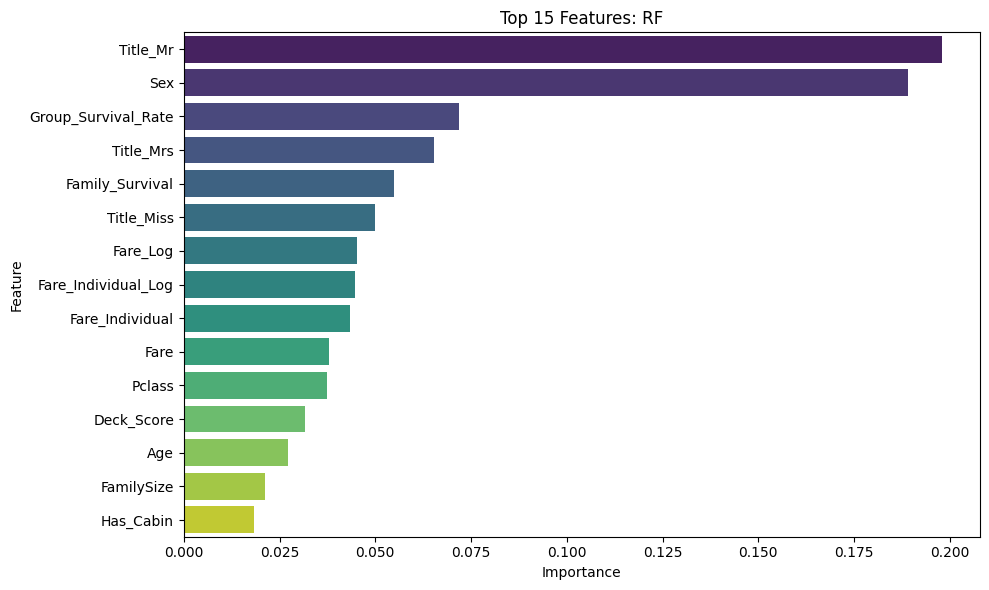


--- XGB TOP FEATURES ---
                Feature  Importance
32             Title_Mr    0.177767
1                   Sex    0.142084
31           Title_Miss    0.103945
33            Title_Mrs    0.077411
0                Pclass    0.066536
15  Group_Survival_Rate    0.059570
16      Family_Survival    0.051647
14           Deck_Score    0.033222
4            FamilySize    0.033055
27               Deck_M    0.032803
13            Has_Cabin    0.031390
10      Fare_Individual    0.028672
11  Fare_Individual_Log    0.026464
17           Embarked_C    0.023808
19           Embarked_S    0.019654


C:\Users\user\AppData\Local\Temp\ipykernel_2344\571376970.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')


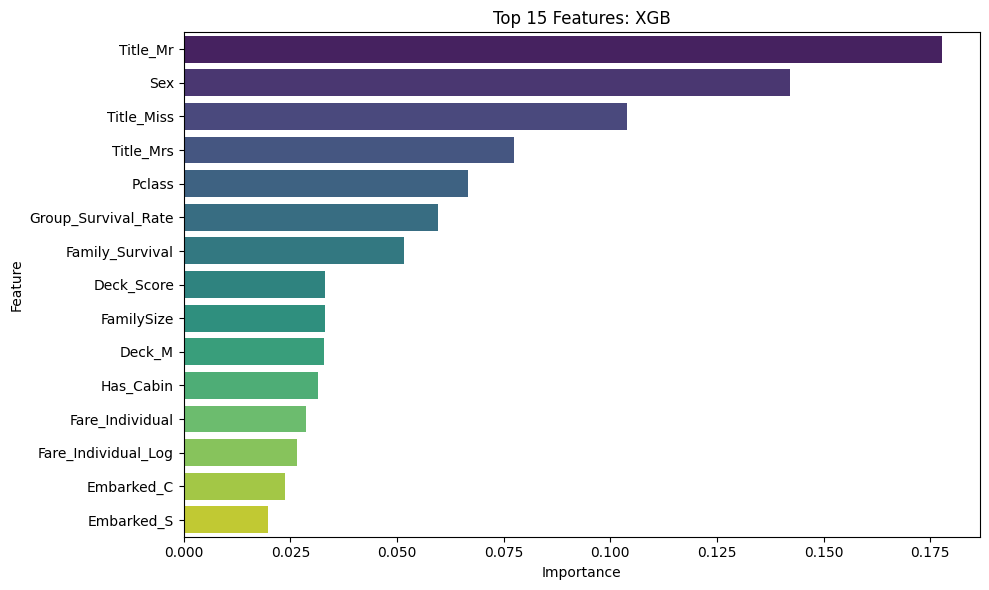

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_importance(stack_model, model_name, feature_names):
    try:
        # 1. Access the wrapper
        wrapper = stack_model.named_estimators_[model_name]
        
        # 2. Extract importances with a safety check for different sklearn versions
        all_importances = []
        for est in wrapper.calibrated_classifiers_:
            # Try getting the model from different possible attribute names
            actual_model = getattr(est, 'estimator', None) or getattr(est, 'base_estimator', None)
            if actual_model:
                all_importances.append(actual_model.feature_importances_)
        
        if not all_importances:
            print(f"Could not find trained models for {model_name}")
            return

        avg_importance = np.mean(all_importances, axis=0)
        
        # 3. Create DataFrame
        df_imp = pd.DataFrame({'Feature': feature_names, 'Importance': avg_importance})
        df_imp = df_imp.sort_values(by='Importance', ascending=False).head(15)

        # 4. Print the data first (in case the plot fails)
        print(f"\n--- {model_name.upper()} TOP FEATURES ---")
        print(df_imp)

        # 5. Visualization
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=df_imp, palette='viridis')
        plt.title(f'Top 15 Features: {model_name.upper()}')
        plt.tight_layout()
        plt.show() # This triggers the window
        
    except Exception as e:
        print(f"An error occurred: {e}")

# Run it
plot_importance(final_model, 'rf', X_train.columns)
plot_importance(final_model, 'xgb', X_train.columns)

In [14]:
weights = final_model.final_estimator_.coef_[0]
intercept = final_model.final_estimator_.intercept_

print(f"Вес Random Forest: {weights[0]:.4f}")
print(f"Вес XGBoost: {weights[1]:.4f}")
print(f"Смещение (Intercept): {intercept[0]:.4f}")

Вес Random Forest: 2.0021
Вес XGBoost: 3.4173
Смещение (Intercept): -2.7161
